# REINFORCE

## Setup

### Installations

In [ ]:
!pip install pygame==1.9.6 pandas==1.0.5 matplotlib==3.2.1 gym==0.17.3
!pip install --upgrade git+git://github.com/david-abel/simple_rl.git@77c0d6b910efbe8bdd5f4f87337c5bc4aed0d79c

### Imports

In [ ]:
import gym
import random
import numpy as np
import json
import os
import pandas as pd
from pathlib import Path
from glob import glob
import subprocess
from collections import namedtuple
from sklearn.decomposition import PCA

from simple_rl.tasks import GymMDP
from simple_rl.agents import PolicyGradientAgent
from simple_rl.run_experiments import run_agents_on_mdp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import matplotlib as mpl
matplotlib.use("agg", force=True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

## Environment

For this experiment I will use the cartpole environment. Then I set the seeds to produce consistent results.

In [ ]:
# Gym MDP
gym_mdp = GymMDP(env_name="CartPole-v1", render=False)
num_feats = gym_mdp.get_num_state_feats()

In [ ]:
GLOBAL_SEED = 0
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
gym_mdp.env.seed(GLOBAL_SEED)

[0]

## Monte Carlo Policy Gradient Methods

Policy gradient methods work by first choosing actions directly from a parameterized model, then secondly updating the weights of the model to nudge the next predictions towards higher expected returns.

REINFORCE achieves this by collecting a full trajectory then updating the policy weights in a Monte Carlo-style.

### REINFORCE Agent
The code below defines the REINFORCE agent. The key to this implementation is that I have manually differentiated the logistic function so the gradient can be calculated directly. In reality you would probably use an automatic differentiation framework, or use a framework that provides the gradients for you.

Once you have the gradient, then all you need to do is use the policy gradient update rule to nudge the parameters towards areas of higher return.

In [ ]:
class LogisticPolicyAgent(PolicyGradientAgent):
    def __init__(self, actions, num_feats):
        self.α = 0.01
        self.γ = 0.99
        self.num_feats = num_feats
        PolicyGradientAgent.__init__(
            self, name="logistic_policy_gradient", actions=actions
        )
        self.reset()

    @staticmethod
    def logistic(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def π(θ, s):
        π = LogisticPolicyAgent.logistic(np.dot(θ.T, s))
        return np.array([π, 1 - π])

    @staticmethod
    def Δ(θ, s):
        π = LogisticPolicyAgent.logistic(np.dot(θ.T, s))
        return np.array([s - s * π, -s * π])

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.episode_history.append(Step(self.previous_pair, reward))
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        return action

    def reset(self):
        self.θ = np.zeros(self.num_feats)
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        T = len(getattr(self, "episode_history", []))
        G = 0
        grad_buf = []
        for t in reversed(range(T)):
            G = G * self.γ + self.episode_history[t].reward
            grad = LogisticPolicyAgent.Δ(self.θ, self.episode_history[t].pair.state)[
                self.episode_history[t].pair.action
            ]
            self.θ += self.α * np.power(self.γ, t) * grad * G
            grad_buf.append(np.power(self.γ, t) * grad * G)
        reinforce_gradient_buffer.append(
            [np.mean(np.abs(grad_buf)), np.std(grad_buf)])
        self.episode_history = []
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)

In [20]:
class LogisticPolicyAgentWithBaseline(PolicyGradientAgent):
    def __init__(self, actions, num_feats, α_θ=0.01, prefix=""):
        self.α_θ = α_θ
        self.α_w = 0.1
        self.γ = 0.99
        self.num_feats = num_feats
        PolicyGradientAgent.__init__(
            self, name=prefix + "logistic_policy_gradient_with_baseline", actions=actions
        )
        self.reset()

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.episode_history.append(Step(self.previous_pair, reward))
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        self.t += 1
        return action

    def reset(self):
        self.θ = np.zeros(self.num_feats)
        self.w = 0
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        self.t = 0
        T = len(getattr(self, "episode_history", []))
        G = 0
        grad_buf = []
        for t in reversed(range(T)):
            G = G * self.γ + self.episode_history[t].reward
            δ = G - self.w
            global_buffer.append(
                np.concatenate(
                    [self.episode_history[t].pair.state, np.array([G])])
            )
            self.w += self.α_w * δ
            Δπ = LogisticPolicyAgent.Δ(self.θ, self.episode_history[t].pair.state)[
                self.episode_history[t].pair.action
            ]
            self.θ += self.α_θ * np.power(self.γ, t) * δ * Δπ
            grad_buf.append(np.power(self.γ, t) * δ * Δπ)
        baseline_gradient_buffer.append(
            [np.mean(np.abs(grad_buf)), np.std(grad_buf)])
        self.episode_history = []
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)

### Training the Agent
Now I’m ready to run the experiment to train the agent. You might want to play around with the instances parameter, which controls the number of repeats to average over.

In [ ]:
Step = namedtuple("Step", ["pair", "reward"])
Pair = namedtuple("Pair", ["state", "action"])

reinforce_gradient_buffer = []
REINFORCE = LogisticPolicyAgent(gym_mdp.get_actions(), num_feats)
run_agents_on_mdp(
    [REINFORCE],
    gym_mdp,
    instances=2,
    episodes=500,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)
np.savetxt("gradient_REINFORCE.txt", np.array(reinforce_gradient_buffer))

Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	logistic_policy_gradient,0
(Params)
	instances : 2
	episodes : 500
	steps : 1000
	track_disc_reward : False

logistic_policy_gradient is learning.
  Instance 1 of 2.
  Instance 2 of 2.


--- TIMES ---
logistic_policy_gradient agent took 37.83 seconds.
-------------

	logistic_policy_gradient: 334.0 (conf_interv: 230.06 )


### Results

In [ ]:
%matplotlib inline

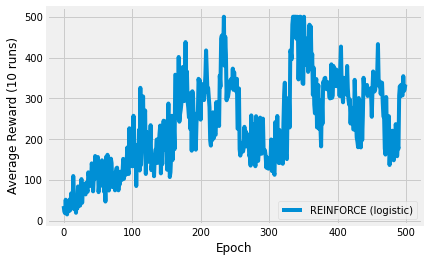

In [ ]:
def plot(experiment_name, data_files, cutoff=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for j, (name, data_file) in enumerate(data_files):
        df = pd.read_csv(data_file, header=None).transpose()
        if cutoff:
            df = df.truncate(after=cutoff)
        x = df.index.values
        y = df.values
        if len(y.shape) > 1:
            y = y.mean(axis=1)
        ax.plot(x,
                y,
                label=name)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Reward (10 runs)')
    ax.legend(loc='lower right')
    plt.show()

data_files = [
    ("REINFORCE (logistic)", "results/gym-CartPole-v1/logistic_policy_gradient.csv"),
]
plot("reinforce_reward_plot", data_files, cutoff=500)

The image above shows the result of plotting the average reward over 500 episodes. The specific curve will depend on your seed and the number of repetitions to average over.

The thing to take away from this experiment is the sheer simplicity of what is going on here. I have defined a very simple model and manually derived the gradient. The environment has 4 continuous features so I need a 4-parameter model. To find an optimal policy, you just need to nudge the gradients towards higher returns. That’s it!

This means that policy gradient methods work really well with continuous state spaces, where value-based methods would struggle, due to the required discretisation.

## REINFORCE with Baseline Policy Gradient Algorithm

The various baseline algorithms attempt to stabilise learning by subtracting the average expected return from the action-values, which leads to stable action-values. Contrast this to vanilla policy gradient or Q-learning algorithms that continuously increment the Q-value, which leads to situations where a minor incremental update to one of the actions causes vast changes in the policy.

In this section I will build upon the previous and also show you how to visualise the discounted reward over various states.

### Reinforce with Baseline Agent
The new agent is basically the same as the standard REINFORCE agent, except for the addition of a weighted moving average to estimate the baseline, which is subtracted from the expected return.

In [ ]:
class LogisticPolicyAgentWithBaseline(PolicyGradientAgent):
    def __init__(self, actions, num_feats, α_θ=0.01, prefix=""):
        self.α_θ = α_θ
        self.α_w = 0.1
        self.γ = 0.99
        self.num_feats = num_feats
        PolicyGradientAgent.__init__(
            self, name=prefix + "logistic_policy_gradient_with_baseline", actions=actions
        )
        self.reset()

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.episode_history.append(Step(self.previous_pair, reward))
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        self.t += 1
        return action

    def reset(self):
        self.θ = np.zeros(self.num_feats)
        self.w = 0
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        self.t = 0
        T = len(getattr(self, "episode_history", []))
        G = 0
        grad_buf = []
        for t in reversed(range(T)):
            G = G * self.γ + self.episode_history[t].reward
            δ = G - self.w
            global_buffer.append(
                np.concatenate(
                    [self.episode_history[t].pair.state, np.array([G])])
            )
            self.w += self.α_w * δ
            Δπ = LogisticPolicyAgent.Δ(self.θ, self.episode_history[t].pair.state)[
                self.episode_history[t].pair.action
            ]
            self.θ += self.α_θ * np.power(self.γ, t) * δ * Δπ
            grad_buf.append(np.power(self.γ, t) * δ * Δπ)
        baseline_gradient_buffer.append(
            [np.mean(np.abs(grad_buf)), np.std(grad_buf)])
        self.episode_history = []
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)

### Training the Agent
Now I’m ready to run the experiment to train the agent. You might want to play around with the instances parameter, which controls the number of repeats to average over.

In [ ]:
Step = namedtuple("Step", ["pair", "reward"])
Pair = namedtuple("Pair", ["state", "action"])

reinforce_gradient_buffer = []
REINFORCE = LogisticPolicyAgent(gym_mdp.get_actions(), num_feats)
run_agents_on_mdp(
    [REINFORCE],
    gym_mdp,
    instances=2,
    episodes=500,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)
np.savetxt("gradient_REINFORCE.txt", np.array(reinforce_gradient_buffer))

global_buffer = []
baseline_gradient_buffer = []
REINFORCE_baseline = LogisticPolicyAgentWithBaseline(
    gym_mdp.get_actions(), num_feats
)
run_agents_on_mdp(
    [REINFORCE_baseline],
    gym_mdp,
    instances=2,
    episodes=500,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)
np.savetxt("state_reward_REINFORCE_baseline.txt", np.array(global_buffer))
np.savetxt("gradient_REINFORCE_baseline.txt",
            np.array(baseline_gradient_buffer))

Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	logistic_policy_gradient,0
(Params)
	instances : 2
	episodes : 500
	steps : 1000
	track_disc_reward : False

logistic_policy_gradient is learning.
  Instance 1 of 2.
  Instance 2 of 2.


--- TIMES ---
logistic_policy_gradient agent took 37.11 seconds.
-------------

	logistic_policy_gradient: 356.0 (conf_interv: 199.57 )
Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	logistic_policy_gradient_with_baseline,0
(Params)
	instances : 2
	episodes : 500
	steps : 1000
	track_disc_reward : False

logistic_policy_gradient_with_baseline is learning.
  Instance 1 of 2.
  Instance 2 of 2.


--- TIMES ---
logistic_policy_gradient_with_baseline agent took 57.66 seconds.
-------------

	logistic_policy_gradient_with_baseline: 433.5 (conf_interv: 92.16 )


### Episode Return

The baseline algorithm needs the ability to predict the return for a given state. This means you need a representative model to be able to predict that. I tried a few things, but quickly realised that the data are remarkably complex. The code below takes some trajectories, runs principal component analysis and plots the result.

Remember that there are four features, so the space is more complex than this. But you can quickly see that the data is strange. It’s shaped like a triangle. This is primarily because the next return depends on the previous; it’s cumulative. Therefore, I thought that I could use a simple online rolling average of previously observed rewards.

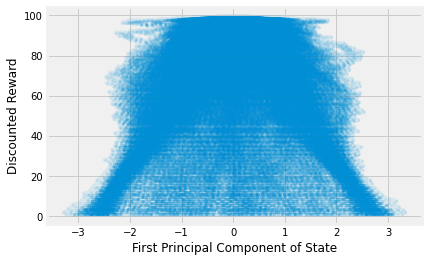

In [ ]:
data = np.loadtxt("state_reward_REINFORCE_baseline.txt")

x = data[:, 0:4]
pca = PCA(n_components=1)
x = pca.fit_transform(x)
y = data[:, 4]

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, y, marker='.', alpha=0.1, markeredgewidth=0.0)
ax.set_xlabel('First Principal Component of State')
ax.set_ylabel('Discounted Reward')
plt.show()

### Results

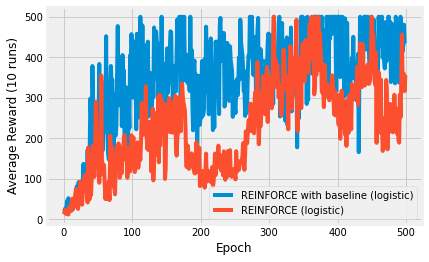

In [ ]:
def plot(experiment_name, data_files, cutoff=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for j, (name, data_file) in enumerate(data_files):
        df = pd.read_csv(data_file, header=None).transpose()
        if cutoff:
            df = df.truncate(after=cutoff)
        x = df.index.values
        y = df.values
        if len(y.shape) > 1:
            y = y.mean(axis=1)
        ax.plot(x,
                y,
                label=name)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Reward (10 runs)')
    ax.legend(loc='lower right')
    plt.show()

data_files = [
    ("REINFORCE with baseline (logistic)", "results/gym-CartPole-v1/logistic_policy_gradient_with_baseline.csv"),
    ("REINFORCE (logistic)", "results/gym-CartPole-v1/logistic_policy_gradient.csv"),
]
plot("reinforce_reward_plot", data_files, cutoff=500)

You can see that the baseline algorithm performs better, just, than the basic REINFORCE algorithm. If you performed more repeats, this would become clearer.

I encourage you to try this yourself with a single repeat. You should be able to observe the baseline algorithm increasing in performance more consistently than the standard algorithm, which seems to repeatedly drop back to zero. This is because of subtle, but catastrophic updates to the Q-values. Sometimes they nudge the policies towards bad policies.

## One-Step Actor-Critic Algorithm
Monte Carlo implementations like those of REINFORCE and baseline do not bootstrap, so they are slow to learn. Temporal difference solutions do bootstrap and can be incorporated into policy gradient algorithms in the same way that n-Step algorithms use it. The addition of n-Step expected returns to the REINFORCE with baseline algorithm yeilds an n-Step actor-critic.

I’m not a huge fan of the actor-critic terminology, because it obfuscates the fact that it is simply REINFORCE with a baseline, where the expected return is implemented as n-Step returns. That’s it.

I’ll implement that below and you’ll be suprised how similar the algorithm is. However, this time I’m going to use tile coding to encode the continous state space, to get a better baseline estimate.

### Tile Coding
Tile coding attemps to split the feature space into discrete bins, where you set the bin to 1 if the value is contained within that bin. If you overlap the bin boundaries, you end up with quite an accurate representation of a continuous feature in discrete form.

In [21]:
# Taken from https://github.com/MeepMoop/tilecoding
class TileCoder:
    def __init__(
        self,
        tiles_per_dim,
        value_limits,
        tilings,
        offset=lambda n: 2 * np.arange(n) + 1,
    ):
        tiling_dims = np.array(np.ceil(tiles_per_dim), dtype=np.int) + 1
        self._offsets = (
            offset(len(tiles_per_dim))
            * np.repeat([np.arange(tilings)], len(tiles_per_dim), 0).T
            / float(tilings)
            % 1
        )
        self._limits = np.array(value_limits)
        self._norm_dims = np.array(tiles_per_dim) / (
            self._limits[:, 1] - self._limits[:, 0]
        )
        self._tile_base_ind = np.prod(tiling_dims) * np.arange(tilings)
        self._hash_vec = np.array(
            [np.prod(tiling_dims[0:i]) for i in range(len(tiles_per_dim))]
        )
        self._n_tiles = tilings * np.prod(tiling_dims)

    def __getitem__(self, x):
        off_coords = (
            (x - self._limits[:, 0]) * self._norm_dims + self._offsets
        ).astype(int)
        return self._tile_base_ind + np.dot(off_coords, self._hash_vec)

    @property
    def n_tiles(self):
        return self._n_tiles

### n-Step Actor-Critic Algorithm
The major addition in this implementation is the use of Tile Coding for the baseline estimate. This improves performance over the previous rolling average method. In addition you will also notice the use of the next state to predict the 1-step expected return. There are no other differences.

In [22]:
class OneStepActorCritic(PolicyGradientAgent):
    @staticmethod
    def v(w, S):
        return np.dot(w.T, S)

    @staticmethod
    def Δv(w, S):
        return S

    def augment(self, S):
        S = S[2:]
        a = np.zeros(self.T.n_tiles)
        a[self.T[S]] = 1
        return a

    def __init__(self, actions, num_feats, α_θ=0.01, α_w=0.1, prefix=""):
        self.α_θ = α_θ
        self.α_w = α_w
        self.γ = 0.99
        self.num_feats = num_feats
        # tile coder tiling dimensions, value limits, number of tilings
        tiles_per_dim = [10] * num_feats
        lims = [(-0.72, 0.72), (-5, 5)]
        tilings = 5
        self.T = TileCoder(tiles_per_dim, lims, tilings)
        print(self.T.n_tiles)
        PolicyGradientAgent.__init__(
            self, name=prefix + "one_step_actor_critic", actions=actions
        )
        self.reset()

    def update(self, state, action, reward, next_state, terminal: bool):
        raw_state = state.copy()
        state = self.augment(state)
        next_state = self.augment(next_state)

        v = self.v(self.w, state)
        if terminal:
            δ = reward + self.γ * 0 - v
        else:
            δ = reward + self.γ * self.v(self.w, next_state) - v
        self.w += self.α_w * δ * self.Δv(self.w, state)
        self.θ += (
            self.α_θ * self.I * δ *
            LogisticPolicyAgent.Δ(self.θ, raw_state)[action]
        )
        self.I *= self.γ

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.update(
                self.previous_pair.state,
                self.previous_pair.action,
                reward,
                state.data,
                state.is_terminal(),
            )
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        self.t += 1
        return action

    def reset(self):
        self.θ = np.zeros(4)
        self.w = np.zeros(self.T.n_tiles)
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        # print(np.mean(self.w), np.std(self.w), np.min(self.w), np.max(self.w), np.count_nonzero(self.w) / self.T.n_tiles)
        self.I = 1
        self.t = 0
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)

### Training the Agent
Now I’m ready to run the experiment to train the agents. I reduce the number of instances to 1 now to save time, since I’m trying to run 4 separate algorithms. If you increase the number of repetitions this will smooth out the results.

In [23]:
Step = namedtuple("Step", ["pair", "reward"])
Pair = namedtuple("Pair", ["state", "action"])

global_buffer = []
baseline_gradient_buffer = []
REINFORCE_baseline = LogisticPolicyAgentWithBaseline(
    gym_mdp.get_actions(), num_feats
)
run_agents_on_mdp(
    [REINFORCE_baseline],
    gym_mdp,
    instances=1,
    episodes=500,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)
np.savetxt("state_reward_REINFORCE_baseline.txt", np.array(global_buffer))
np.savetxt("gradient_REINFORCE_baseline.txt",
            np.array(baseline_gradient_buffer))

TDAC_slow = OneStepActorCritic(
    gym_mdp.get_actions(), 2, α_θ=0.1, α_w=0.01, prefix="slow_weight_")
TDAC_fast = OneStepActorCritic(
    gym_mdp.get_actions(), 2, α_θ=0.1, α_w=0.1, prefix="fast_weight_")
TDAC_super_fast = OneStepActorCritic(
    gym_mdp.get_actions(), 2, α_θ=0.1, α_w=0.5, prefix="super_fast_weight_")
run_agents_on_mdp(
    [TDAC_slow, TDAC_fast, TDAC_super_fast],
    gym_mdp,
    instances=1,
    episodes=500,
    steps=500,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)

Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	logistic_policy_gradient_with_baseline,0
(Params)
	instances : 1
	episodes : 500
	steps : 1000
	track_disc_reward : False

logistic_policy_gradient_with_baseline is learning.
  Instance 1 of 1.


--- TIMES ---
logistic_policy_gradient_with_baseline agent took 28.25 seconds.
-------------

	logistic_policy_gradient_with_baseline: 500.0 (conf_interv: 0.0 )
605
605
605
Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	slow_weight_one_step_actor_critic,0
	fast_weight_one_step_actor_critic,1
	super_fast_weight_one_step_actor_critic,2
(Params)
	instances : 1
	episodes : 500
	steps : 500
	track_disc_reward : False

slow_weight_one_step_actor_critic is learning.
  Instance 1 of 1.

fast_weight_one_step_actor_critic is learning.
  Instance 1 of 1.

super_fast_weight_one_step_actor_critic is learning.
  Instance 1 of 1.


--- TIMES ---
slow_weight_one_step_actor_critic agent took 29.19 seconds.
fast_weight_one_step_actor_critic agent took

### Results

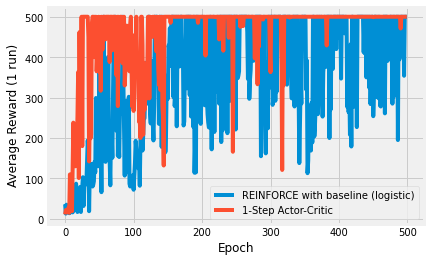

In [24]:
def plot(experiment_name, data_files, cutoff=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for j, (name, data_file) in enumerate(data_files):
        df = pd.read_csv(data_file, header=None).transpose()
        if cutoff:
            df = df.truncate(after=cutoff)
        x = df.index.values
        y = df.values
        if len(y.shape) > 1:
            y = y.mean(axis=1)
        ax.yaxis.major.formatter._useMathText = True
        ax.plot(x,
                y,
                label=name)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Reward (1 run)')
    ax.legend(loc='lower right')
    plt.show()

data_files = [
    ("REINFORCE with baseline (logistic)", "results/gym-CartPole-v1/logistic_policy_gradient_with_baseline.csv"),
    ("1-Step Actor-Critic", "results/gym-CartPole-v1/fast_weight_one_step_actor_critic.csv"),
]
plot("reinforce_reward_plot", data_files, cutoff=500)

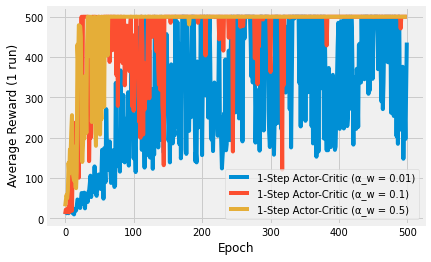

In [25]:
data_files = [
    ("1-Step Actor-Critic (α_w = 0.01)", "results/gym-CartPole-v1/slow_weight_one_step_actor_critic.csv"),
    ("1-Step Actor-Critic (α_w = 0.1)", "results/gym-CartPole-v1/fast_weight_one_step_actor_critic.csv"),
    ("1-Step Actor-Critic (α_w = 0.5)", "results/gym-CartPole-v1/super_fast_weight_one_step_actor_critic.csv"),
]
plot("reinforce_reward_plot", data_files, cutoff=500)

Algorithms that can bootstrap, or in other words, algorithms that can learn from the get-go, learn faster than those that have to wait until an episode is over. n-step algorithms do this and the first plots demonstrates the increase in performance. The plot is a little noisy due to no averaging.

The second image shows the difference between different learning rate parameters. The fastest (0.5) is very unstable. Sometimes it learns, other times it doesn’t, because the policy is changing on each step. The slow (0.01) has a similar performance to the Monte Carlo methods. The learning rate in the middle (0.1) learns fast and is about as stable as the other algorithms. This demonstrates how you must tune your hyperparameters to your specific problem.